# Sentiment Analysis with Deep Learning using BERT

### Prerequisites

- Intermediate-level knowledge of Python 3 (NumPy and Pandas preferably, but not required)
- Exposure to PyTorch usage
- Basic understanding of Deep Learning and Language Models (BERT specifically)

### Project Outline

**Task 1**: Introduction (this section)

**Task 2**: Exploratory Data Analysis and Preprocessing

**Task 3**: Training/Validation Split

**Task 4**: Loading Tokenizer and Encoding our Data

**Task 5**: Setting up BERT Pretrained Model

**Task 6**: Creating Data Loaders

**Task 7**: Setting Up Optimizer and Scheduler

**Task 8**: Defining our Performance Metrics

**Task 9**: Creating our Training Loop

## Introduction

### What is BERT

BERT is a large-scale transformer-based Language Model that can be finetuned for a variety of tasks.

For more information, the original paper can be found [here](https://arxiv.org/abs/1810.04805). 

[HuggingFace documentation](https://huggingface.co/transformers/model_doc/bert.html)

[Bert documentation](https://characters.fandom.com/wiki/Bert_(Sesame_Street) ;)

<img src="Images/BERT_diagrams.pdf" width="1000">

## Exploratory Data Analysis and Preprocessing

We will use the SMILE Twitter dataset.

_Wang, Bo; Tsakalidis, Adam; Liakata, Maria; Zubiaga, Arkaitz; Procter, Rob; Jensen, Eric (2016): SMILE Twitter Emotion dataset. figshare. Dataset. https://doi.org/10.6084/m9.figshare.3187909.v2_

In [ ]:
import torch
import pandas as pd
from tqdm.notebook import tqdm
import csv
import numpy as np

In [ ]:
# df = pd.read_csv('circa-data.tsv')
df = pd.read_csv('circa-data.tsv', delimiter="\t", encoding='utf-8',quoting=csv.QUOTE_NONE,usecols=['context','questionX','answerY','goldstandard1','goldstandard2'])
# df.set_index('id', inplace=True)

In [ ]:
df.dropna(subset=["goldstandard2"], inplace=True)

In [ ]:
df = df[df.goldstandard2 != 'Other']
print(len(df))

32993


In [ ]:
df.sample(5)

,context,questionX,answerY,goldstandard1,goldstandard2
2941,Y has just told X that he/she is thinking of b...,Is the flat affordable?,It's below market price.,NaN,Yes
33344,X wants to know what sorts of books Y likes to...,Do you prefer horror?,I like mysteries the most.,No,No
9962,Y has just told X that he/she is thinking of b...,Are you moving soon?,As soon as I can.,NaN,Yes
11350,X wants to know about Y's music preferences.,Do you like loud music?,I'd rather listen more quietly.,No,No
26903,X wants to know what activities Y likes to do ...,Have you seen the newest releases on Netflix?,I am the only person I know without a Netflix ...,No,No


In [ ]:
df.goldstandard2.value_counts()

Yes                                  16628
No                                   12833
Yes, subject to some conditions       2583
In the middle, neither yes nor no      949
Name: goldstandard2, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

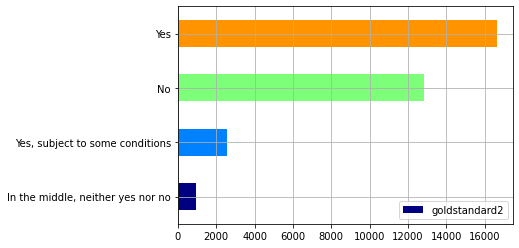

In [ ]:
colors = cm.jet(np.linspace(0,1,5))
df.goldstandard2.value_counts().sort_values().plot(kind = 'barh',grid = True, legend = True,color=colors)


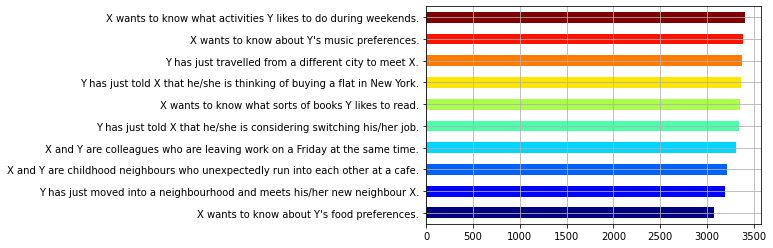

In [ ]:
colors = cm.jet(np.linspace(0,1,10))
df.context.value_counts().sort_values().plot(kind = 'barh',grid = True,color=colors)

In [ ]:
possible_labels = df.goldstandard2.unique()

In [ ]:
possible_labels

array(['Yes', 'No', 'In the middle, neither yes nor no',
       'Yes, subject to some conditions'], dtype=object)

In [ ]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [ ]:
label_dict

{'In the middle, neither yes nor no': 2,
 'No': 1,
 'Yes': 0,
 'Yes, subject to some conditions': 3}

In [ ]:
df['goldstandard2'] = df.goldstandard2.replace(label_dict)

In [ ]:
df.head()

,context,questionX,answerY,goldstandard1,goldstandard2
0,Y has just travelled from a different city to ...,Are you employed?,I'm a veterinary technician.,Yes,0
1,X wants to know about Y's food preferences.,Are you a fan of Korean food?,I wouldn't say so,No,1
2,Y has just told X that he/she is thinking of b...,Are you bringing any pets into the flat?,I do not own any pets,No,1
3,X wants to know what activities Y likes to do ...,Would you like to get some fresh air in your f...,I am desperate to get out of the city.,Yes,0
4,X and Y are childhood neighbours who unexpecte...,Is your family still living in the neighborhood?,My parents are snowbirds now.,"In the middle, neither yes nor no",2


## Training/Validation Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val_test, y_train, y_val_test = train_test_split(df.index.values, 
                                                  df.goldstandard2.values, 
                                                  test_size=0.6, 
                                                  random_state=17, 
                                                  stratify=df.goldstandard2.values)
X_test, X_val, y_test, y_val = train_test_split(df.loc[X_val_test].index.values, 
                                                  df.loc[X_val_test].goldstandard2.values, 
                                                  test_size=0.5, 
                                                  random_state=17, 
                                                  stratify=df.loc[X_val_test].goldstandard2.values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

In [ ]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test,'data_type'] = 'test'

In [ ]:
df.sample(5)

,context,questionX,answerY,goldstandard1,goldstandard2,data_type
24337,Y has just told X that he/she is thinking of b...,Have you been to New York?,I've visited every summer since college.,Yes,0,test
29221,Y has just told X that he/she is thinking of b...,Is the price reasonable?,It is pretty good,Yes,0,train
32315,X wants to know what sorts of books Y likes to...,Do you like non-fiction?,I prefer a good tale.,No,1,test
9471,X wants to know what sorts of books Y likes to...,You like fantasy books?,"I love reading about dragons, spells and witches.",Yes,0,val
30493,X and Y are colleagues who are leaving work on...,Are you caught up with your work?,I finished this morning.,Yes,0,train


In [ ]:
ans = df.groupby(['context']).count()

## Loading Tokenizer and Encoding our Data

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].questionX.values  + '[SEP]' + df[df.data_type=='train'].answerY.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=25, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].questionX.values  + '[SEP]' + df[df.data_type=='val'].answerY.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=25, 
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    df[df.data_type=='test'].questionX.values  + '[SEP]' + df[df.data_type=='test'].answerY.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=25, 
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].goldstandard2.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].goldstandard2.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(df[df.data_type=='test'].goldstandard2.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# df[df.data_type=='train'].questionX.values  + '[SEP]' + df[df.data_type=='train'].answerY.values

array(["Are you employed?[SEP]I'm a veterinary technician.",
       'Are you bringing any pets into the flat?[SEP]I do not own any pets',
       'Is your family still living in the neighborhood?[SEP]My parents are snowbirds now.',
       ..., 'Do you drink beer?[SEP]All alcohol is great.',
       'Do you like pie?[SEP]My favorite pie is pecan.',
       "Want to go to a concert with me?[SEP]I'd rather do something else."],
      dtype=object)

In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [ ]:
len(dataset_train)

13197

In [ ]:
len(dataset_val)

9898

In [ ]:
len(dataset_test)

9898

## Setting up BERT Pretrained Model

In [ ]:
from transformers import BertForSequenceClassification

In [ ]:
import torch.nn as nn

In [ ]:
# model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
#                                                       num_labels=len(label_dict),
#                                                       output_attentions=False,
#                                                       output_hidden_states=False)
#"ishan/bert-base-uncased-mnli"


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# model = BertForSequenceClassification.from_pretrained("ishan/bert-base-uncased-mnli",
#                                                       num_labels=3,
#                                                       output_attentions=False,
#                                                       output_hidden_states=False)

In [ ]:
model = BertForSequenceClassification.from_pretrained("howey/bert-base-uncased-boolq",
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

In [ ]:
model.classifier = nn.Linear(in_features=768, out_features=4, bias=True)
model.num_labels = 4

In [ ]:
model

## Creating Data Loaders

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:
batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=batch_size)

## Setting Up Optimiser and Scheduler

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr=5e-5, 
                  eps=1e-8)

In [ ]:
epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## Defining our Performance Metrics

Accuracy metric approach originally used in accuracy function in [this tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification).

In [ ]:
import numpy as np

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [ ]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    total_correct = 0;total_samples = 0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}')
        print('Correct Predictions ', str(label) , len(y_preds[y_preds==label])/len(y_true))
        total_correct += len(y_preds[y_preds==label])
        total_samples += len(y_true)
    print('Total Correct Predictions ',total_correct/total_samples)

## Creating our Training Loop

Approach adapted from an older version of HuggingFace's `run_glue.py` script. Accessible [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/413 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.6086972456867412
Validation loss: 0.4961890056248634
F1 Score (Weighted): 0.8018192816179537


Epoch 2:   0%|          | 0/413 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.35657226335771436
Validation loss: 0.474234892740365
F1 Score (Weighted): 0.8373502384314581


Epoch 3:   0%|          | 0/413 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.20172365335409348
Validation loss: 0.5149175029728682
F1 Score (Weighted): 0.8477979274901382


In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [ ]:
accuracy_per_class(predictions, true_vals)

Class: Yes
Accuracy: 4348/4988
Correct Predictions  0 0.871692060946271
Class: No
Accuracy: 3313/3850
Correct Predictions  1 0.8605194805194806
Class: In the middle, neither yes nor no
Accuracy: 78/285
Correct Predictions  2 0.2736842105263158
Class: Yes, subject to some conditions
Accuracy: 685/775
Correct Predictions  3 0.8838709677419355
Total Correct Predictions  0.851081026469994


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
preds = np.argmax(predictions, axis=1).flatten()
target_names = ['Yes','No','In the middle, neither yes nor no','Yes, subject to some conditions']
print(classification_report(true_vals,preds,target_names=target_names,digits=3))

                                   precision    recall  f1-score   support

                              Yes      0.872     0.872     0.872      4988
                               No      0.833     0.861     0.847      3850
In the middle, neither yes nor no      0.510     0.274     0.356       285
  Yes, subject to some conditions      0.876     0.884     0.880       775

                         accuracy                          0.851      9898
                        macro avg      0.773     0.722     0.739      9898
                     weighted avg      0.847     0.851     0.848      9898



In [ ]:
_, predictions, true_vals = evaluate(dataloader_test)

In [ ]:
accuracy_per_class(predictions, true_vals)

Class: Yes
Accuracy: 4366/4989
Correct Predictions  0 0.8751252756063339
Class: No
Accuracy: 3306/3850
Correct Predictions  1 0.8587012987012987
Class: In the middle, neither yes nor no
Accuracy: 64/284
Correct Predictions  2 0.22535211267605634
Class: Yes, subject to some conditions
Accuracy: 687/775
Correct Predictions  3 0.8864516129032258
Total Correct Predictions  0.8509799959587796


In [ ]:
preds = np.argmax(predictions, axis=1).flatten()
target_names = ['Yes','No','In the middle, neither yes nor no','Yes, subject to some conditions']
print(classification_report(true_vals,preds,target_names=target_names,digits=3))

                                   precision    recall  f1-score   support

                              Yes      0.873     0.875     0.874      4989
                               No      0.833     0.859     0.846      3850
In the middle, neither yes nor no      0.508     0.225     0.312       284
  Yes, subject to some conditions      0.861     0.886     0.873       775

                         accuracy                          0.851      9898
                        macro avg      0.769     0.711     0.726      9898
                     weighted avg      0.846     0.851     0.847      9898



In [ ]:
#------load saved model then run--------

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

In [ ]:
model.load_state_dict(torch.load('Models/<<INSERT MODEL NAME HERE>>.model', map_location=torch.device('cpu')))

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [ ]:
accuracy_per_class(predictions, true_vals)

In [ ]:
preds = np.argmax(predictions, axis=1).flatten()
target_names = ['Yes','No','Yes, subject to some conditions','In the middle, neither yes nor no','Other']
print(classification_report(true_vals,preds,target_names=target_names))

In [ ]:
#--------BOOLQ BASELINE---------------

In [ ]:
model = BertForSequenceClassification.from_pretrained("howey/bert-base-uncased-boolq",
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model.to(device)

print(device)

cpu


In [ ]:
model.eval()

In [ ]:
len(dataloader_validation)

310

In [ ]:
def run_baseline(model,dataloader = dataloader_validation):
  count = 0
  predictions, true_vals = [], []
  while count<=len(dataloader):
    batch = next(iter(dataloader))
    inputs = {'input_ids':      batch[0],
              'attention_mask': batch[1],
              }
    labels = {'labels':batch[2]}
    with torch.no_grad():
      outputs = model(**inputs)
    # loss = outputs[0]
    logits = outputs[0]
    # loss_val_total += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = labels['labels'].cpu().numpy()
    predictions.append(logits)
    true_vals.append(label_ids)
    count+=1
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)
  return predictions,true_vals

In [ ]:
print(len(dataloader_validation))
count = 0
predictions, true_vals = [], []
while count<=len(dataloader_validation):
  batch = next(iter(dataloader_validation))
  inputs = {'input_ids':      batch[0],
            'attention_mask': batch[1],
            }
  labels = {'labels':batch[2]}
  with torch.no_grad():
    outputs = model(**inputs)
  # loss = outputs[0]
  logits = outputs[0]
  # loss_val_total += loss.item()

  logits = logits.detach().cpu().numpy()
  label_ids = labels['labels'].cpu().numpy()
  predictions.append(logits)
  true_vals.append(label_ids)
  count+=1
predictions = np.concatenate(predictions, axis=0)
true_vals = np.concatenate(true_vals, axis=0)

310


In [ ]:
preds_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_vals.flatten()
total_correct = 0;total_samples = 0
for label in np.unique(labels_flat):
    y_preds = preds_flat[labels_flat==label]
    y_true = labels_flat[labels_flat==label]
    # print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}')
    # print('Correct Predictions ', str(label) , len(y_preds[y_preds==label])/len(y_true))
    total_correct += len(y_preds[y_preds==label])
    total_samples += len(y_true)
print('Total Correct Predictions ',total_correct/total_samples)

Total Correct Predictions  0.5625


In [ ]:
def accuracy_evaluate(predictions,true_vals):
  preds_flat = np.argmax(predictions, axis=1).flatten()
  labels_flat = true_vals.flatten()
  total_correct = 0;total_samples = 0
  for label in np.unique(labels_flat):
      y_preds = preds_flat[labels_flat==label]
      y_true = labels_flat[labels_flat==label]
      # print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}')
      # print('Correct Predictions ', str(label) , len(y_preds[y_preds==label])/len(y_true))
      total_correct += len(y_preds[y_preds==label])
      total_samples += len(y_true)
  print('Total Correct Predictions ',total_correct/total_samples)

Total Correct Predictions  0.5625


In [ ]:
print(classification_report(true_vals,preds_flat,digits=3))

              precision    recall  f1-score   support

           0      0.737     0.824     0.778      5287
           1      0.462     0.750     0.571      2488
           2      0.000     0.000     0.000       933
           3      0.000     0.000     0.000      1244

    accuracy                          0.625      9952
   macro avg      0.300     0.393     0.337      9952
weighted avg      0.507     0.625     0.556      9952



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
!CUDA_LAUNCH_BLOCKING=1